# Characterizing Morphogenesis on Mouse Heart Organogenesis based on Gaussian Processes

The formation of an embryo and constituent organs is characterized by a tightly regulated morphogenetic process.
In this tutorial, you will learn how to predict each individual cell migrates over time based on two temporal snapshots of the mouse heart. Ultimately, this will allow you to connect macroscopic morphological changes with microscopic molecular expression dynamics in single cells across space.

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running this notebook on: ", device)

import spateo as st
print("Last run with spateo version:", st.__version__)

# Other imports
import warnings, string
import anndata as ad
import dynamo as dyn
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Uncomment the following if running on the server
import pyvista as pv
pv.start_xvfb()

sns.set_theme(context="paper", style="ticks", font_scale=1)
warnings.filterwarnings('ignore')
# %load_ext autoreload
# %autoreload 2

Running this notebook on:  cuda
Last run with spateo version: 1.1.0.dev44+cbea5b3.dirty


In [2]:
# initialize colormap
lscmap = mpl.cm.get_cmap("vlag_r")
regions = ["Left ventricle", "Right ventricle", "Outflow tract", "Right atrium", "Left atrium"]
regions_hex_list = [mpl.colors.to_hex(lscmap(i)) for i in np.linspace(0, 1, len(regions))]
regions_colors = {i: j for i, j in zip(regions, regions_hex_list)}

## Loading the Data

In this tutorial, we will use the temporal data of mouse heart extracted from the two-time-point mouse embryo molecular holograms. You can download the raw data from [SpateoData](https://spateodata.aristoteleo.com/#mouse). After downloading, be sure to place the data in the appropriate directory.

In [6]:
E95_adata = st.read_h5ad(f"./data/mouse_E9.5_heart.h5ad")
# remove some useless genes
E95_adata = E95_adata[:, ~E95_adata.var.index.str.endswith('Rik')]
E95_adata = E95_adata[:, ~E95_adata.var.index.str.endswith('Rik8')]
E95_adata = E95_adata[:, ~E95_adata.var.index.str.startswith('Gm')]
E95_adata = E95_adata[:, ~E95_adata.var.index.str.startswith('a')]
for letter1 in string.ascii_uppercase:
    for letter2 in string.ascii_uppercase:
        E95_adata = E95_adata[:, ~E95_adata.var.index.str.startswith(f'{letter1}{letter2}')]
        
E115_adata = st.read_h5ad(f"./data/mouse_E11.5_heart.h5ad")
# remove some useless genes
E115_adata = E115_adata[:, ~E115_adata.var.index.str.endswith('Rik')]
E115_adata = E115_adata[:, ~E115_adata.var.index.str.endswith('Rik8')]
E115_adata = E115_adata[:, ~E115_adata.var.index.str.startswith('Gm')]
E115_adata = E115_adata[:, ~E115_adata.var.index.str.startswith('a')]
for letter1 in string.ascii_uppercase:
    for letter2 in string.ascii_uppercase:
        E115_adata = E115_adata[:, ~E115_adata.var.index.str.startswith(f'{letter1}{letter2}')]
print(E95_adata, E115_adata)

View of AnnData object with n_obs × n_vars = 19780 × 12163
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'louvain', 'cellbin_SpatialDomain', 'slices', 'reclustering', 'heart_anno', 'heart_regions', 'stage', '3d_spatial_density_heart_regions'
    obsm: '3d_align_spatial', 'aligned_spatial_3D', 'aligned_spatial_3D_mm', 'aligned_spatial_3D_new'
    layers: 'total' View of AnnData object with n_obs × n_vars = 98966 × 17869
    obs: 'ctype_user', 'cml', 'slices', 'heart_anno', 'heart_regions', 'stage', '3d_spatial_density_heart_regions'
    obsm: '3d_align_spatial', 'aligned_spatial_3D', 'aligned_spatial_3D_mm', 'aligned_spatial_3D_new'
    layers: 'total'


Let’s visualize the 3D temporal structure of the mouse heart.

<div class="alert alert-warning">
<strong>Warning:</strong>

The following code block involves [PyVista](https://docs.pyvista.org/) visualization. Before running the PyVista-based visualization function `st.pl.three_d_plot`, please ensure that PyVista is installed correctly, especially for server configurations. Incorrect installation may cause Jupyter Notebook to crash. There are certain specifications to consider when running PyVista on a remote server. We recommend reviewing their [tutorials](https://docs.pyvista.org/user-guide/jupyter/trame.html#remote-jupyter-host), particularly for remote Jupyter environments.
    
</div>

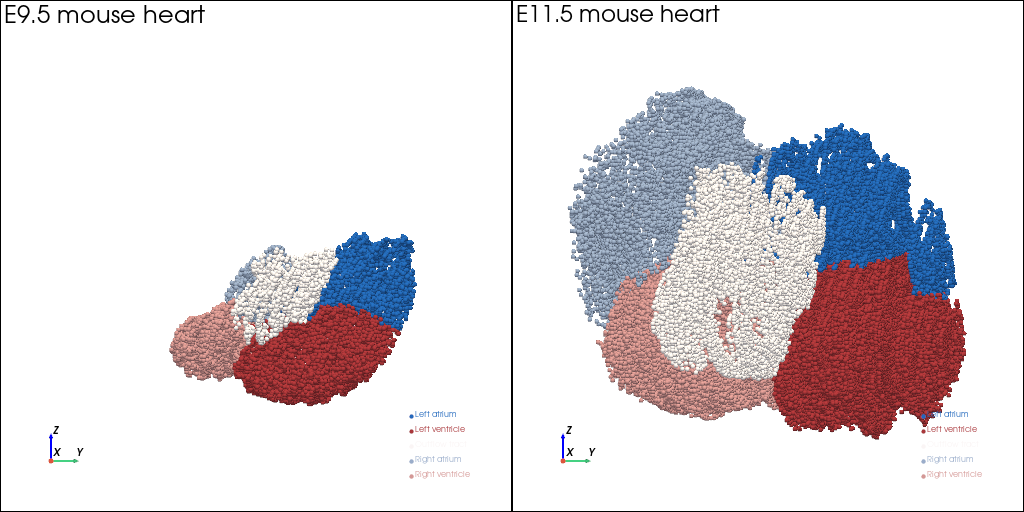

In [8]:
E95_pc, _ = st.tdr.construct_pc(adata=E95_adata,spatial_key='3d_align_spatial',groupby='heart_regions', key_added='heart_regions', colormap=regions_colors)
E115_pc, _ = st.tdr.construct_pc(adata=E115_adata,spatial_key='3d_align_spatial',groupby='heart_regions', key_added='heart_regions', colormap=regions_colors)
cpo = [(4132.5, 505.6, 581.8),(283.8, 505.6, 581.8), (0.0, 0.0, 1.0)]
st.pl.three_d_multi_plot(
    model=st.tdr.collect_models([E95_pc, E115_pc]),
    key='heart_regions',
    model_style="points",
    jupyter="static",
    cpo=[cpo],
    model_size=5,
    text=['E9.5 mouse heart', 'E11.5 mouse heart']
)

## Preprocessing

First, we perform preprocessing using Dynamo's framework to select highly variable genes.

In [9]:
# Preprocess
common_genes = np.intersect1d(E95_adata.var_names, E115_adata.var_names)

E95_adata = E95_adata[:, E95_adata.var_names.isin(common_genes)].copy()
E95_adata.obs.index = f"E9.5_" + E95_adata.obs.index

E115_adata = E115_adata[:, E115_adata.var_names.isin(common_genes)].copy()
E115_adata.obs.index = f"E11.5_" + E115_adata.obs.index

combined_adata = ad.concat([E95_adata, E115_adata])
dyn.pp.select_genes_by_pearson_residuals(adata=combined_adata, n_top_genes=200, inplace=True)
combined_hvg_adata = combined_adata[:, combined_adata.var["gene_highly_variable"]].copy()

E95_hvg_adata = combined_hvg_adata[combined_hvg_adata.obs['stage'] == 'E9.5']
E115_hvg_adata = combined_hvg_adata[combined_hvg_adata.obs['stage'] == 'E11.5']
E95_hvg_adata, E115_hvg_adata

|-----> gene selection on layer: X
|-----> extracting highly variable genes
|-----------> filtered out 0 outlier genes


(View of AnnData object with n_obs × n_vars = 19780 × 200
     obs: 'slices', 'heart_anno', 'heart_regions', 'stage', '3d_spatial_density_heart_regions'
     var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'gene_highly_variable', 'use_for_pca'
     uns: 'pp'
     obsm: '3d_align_spatial', 'aligned_spatial_3D', 'aligned_spatial_3D_mm', 'aligned_spatial_3D_new'
     layers: 'total',
 View of AnnData object with n_obs × n_vars = 98966 × 200
     obs: 'slices', 'heart_anno', 'heart_regions', 'stage', '3d_spatial_density_heart_regions'
     var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'gene_highly_variable', 'use_for_pca'
     uns: 'pp'
     obsm: '3d_align_spatial', 'aligned_spatial_3D', 'aligned_spatial_3D_mm', 'aligned_spatial_3D_new'
     layers: 'total')

## Spatiotemporal Mapping and Alignment

Since the heart region is relatively well-developed, incorporating label information can improve the quality of spatiotemporal mapping and alignment. Therefore, we introduce a label prior. Here, we use the function ``st.align.morpho_align`` to do the spatiotemporal mapping and alignment, which is the same as the 2D slice alignment case. 

Although the function has many additional input parameters, it is actually quite simple. We can break it down into the following parts:

- Nonrigid part, refer [nonrigid tutorial](../3_alignment/2.%20Nonrigid%20alignment%20of%20Spateo%20for%202D%20slices.ipynb) to learn the meaning of each parameter

```python
beta=0.2,
lambdaVF=1,
K = 200,
```
- Define the input feature, refer [basic tutorial](../3_alignment/1.%20Basic%20usage%20of%20Spateo%20alignment%20for%202D%20slices.ipynb) to learn how to set the input feature as well as the label prior information

```python
rep_layer=['X', 'heart_regions'],
rep_field=['layer', 'obs'],
dissimilarity=['kl', 'label'],
label_transfer_dict=label_transfer_prior,
probability_parameters=[0.2, None],
```
- Acceleration and scalability part, refer [efficiency and scalibility tutorial](../3_alignment/4.%20Improve%20efficiency%20and%20scalibity.ipynb) to learn how to use sparse calculation

```python
sparse_calculation_mode=True,
use_chunk=True,
chunk_capacity=2,
```
- Default setting for 3D spatiotemporal mapping

```python
partial_robust_level=1, # because no partial overlap here, so we set it to 1
return_mapping=True,    # we want to full mapping return, so we set it to True
nn_init=False,          # as the heart is pre-aligned, so nn_init is not needed and set to False
sigma2_init_scale=2,    # add some initial noise
separate_scale=True,    # as two heart has different scale, we can use different normalization scale to make mapping more accurate

```

In [11]:
label_transfer_prior = {
    'Left ventricle': {'Left ventricle': 0.96, 'Left atrium': 0.01, 'Outflow tract': 0.01, 'Right atrium': 0.01, 'Right ventricle': 0.01},
    'Left atrium': {'Left ventricle': 0.01, 'Left atrium': 0.96, 'Outflow tract': 0.01, 'Right atrium': 0.01, 'Right ventricle': 0.01},
    'Outflow tract': {'Left ventricle': 0.01, 'Left atrium': 0.01, 'Outflow tract': 0.96, 'Right atrium': 0.01, 'Right ventricle': 0.01},
    'Right atrium': {'Left ventricle': 0.01, 'Left atrium': 0.01, 'Outflow tract': 0.01, 'Right atrium': 0.96, 'Right ventricle': 0.01},
    'Right ventricle': {'Left ventricle': 0.01, 'Left atrium': 0.01, 'Outflow tract': 0.01, 'Right atrium': 0.01, 'Right ventricle': 0.96},
}

mapped_adatas, mapping_pis = st.align.morpho_align(
    models=[E115_hvg_adata.copy(), E95_hvg_adata.copy()],
    spatial_key='3d_align_spatial',
    key_added='3d_align_spatial_morpho',
    device='2',
    verbose=True,

    # Nonrigid part
    beta=0.2,
    lambdaVF=1,
    K = 200,

    # input feature
    rep_layer=['X', 'heart_regions'],
    rep_field=['layer', 'obs'],
    dissimilarity=['kl', 'label'],
    label_transfer_dict=label_transfer_prior,
    probability_parameters=[0.2, None],

    # Acceleration and scalability
    sparse_calculation_mode=True,
    use_chunk=True,
    chunk_capacity=2,

    # Default setting for 3D spatiotemporal mapping
    partial_robust_level=1,
    return_mapping=True,
    nn_init=False,
    sigma2_init_scale=2,
    separate_scale=True,
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%|-----> Filtered all samples for common genes. There are 200 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([293.4735, 516.6395], device='cuda:0')...
|-----------> Mean: tensor([[348.2713, 694.6521, 311.6095],
        [260.4510, 535.0177, 404.5883]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Using chunk calculation
|-----------> split_size: 10111.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [34.7307s]
|-----> Key Parameters: gamma: 0.9900000095367432; sigma2: 0.04717884585261345; probability_parameters: [0.2, None]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [4.1752s]


Extract the output results

In [12]:
# Transition matrix of mapping 
E95_mapped_adata = mapped_adatas[1]
E115_mapped_adata = mapped_adatas[0]

# Turn the mapping matrix to dense matrix
mapping_pis[0] = mapping_pis[0].A.T

We can show the transition matrix calculated from the mapping matrix

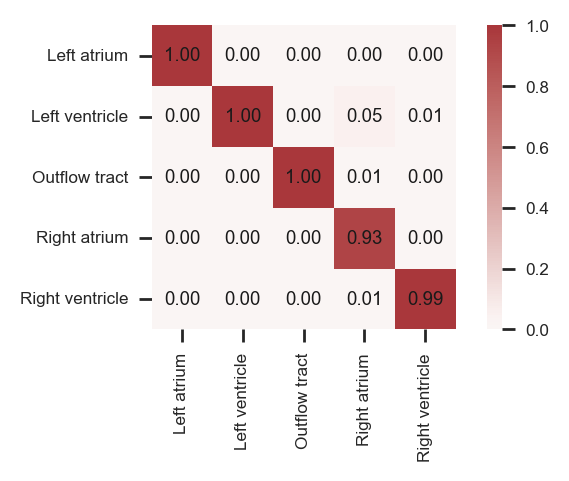

In [13]:
cat1 = E95_mapped_adata.obs['heart_regions'].cat.categories.values
cat2 = E115_mapped_adata.obs['heart_regions'].cat.categories.values
confusion_matrix = np.zeros((len(cat1), len(cat2)))
for i in range(E95_mapped_adata.shape[0]):
    self_label = E95_mapped_adata[i].obs['heart_regions'].values[0]
    transfer_label = E115_mapped_adata[np.argmax(mapping_pis[0][i])].obs['heart_regions'].values[0]
    index1 = np.where(cat1 == self_label)[0][0]
    index2 = np.where(cat2 == transfer_label)[0][0]
    confusion_matrix[index1, index2] += 1
confusion_matrix_norm = confusion_matrix.copy()
confusion_matrix_norm = confusion_matrix_norm / np.expand_dims(np.sum(confusion_matrix_norm, axis=0), 0)

matrix = pd.DataFrame(data=confusion_matrix_norm, columns=cat2, index=cat1)
sns.set_theme(context="paper", style="ticks", font_scale=0.7)
f, ax = plt.subplots(figsize=(4, 2))
sns.heatmap(matrix, cmap="vlag", annot=True, fmt=".2f", annot_kws={"color": "k"}, linewidths=0, square=True, center=0)
plt.show()

## Visualization of the spatiotemporal mapping

We can visualize the spatiotemporal mapping across two mouse heart using Spateo's visualization function ``st.pl.three_d_plot``. To begin, we need to construct the mapping lines using ``np.argmax`` and ``st.tdr.construct_align_lines``. Note that you can set ``jupyter`` to ``'html'`` in ``st.pl.three_d_plot`` to get a interactive 3D visualization.

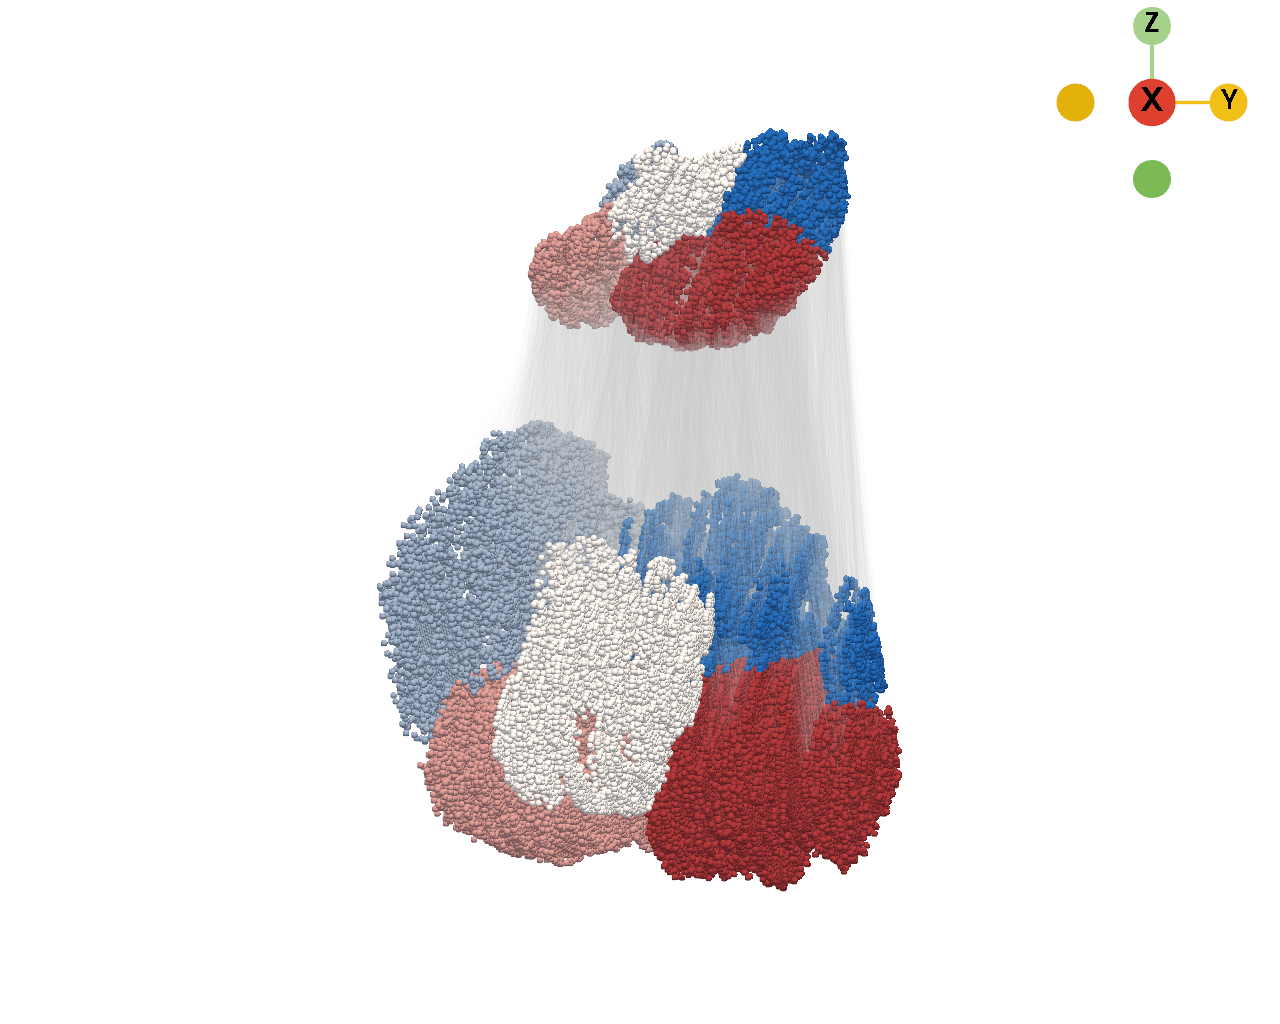

In [15]:
shift_E115_pc = E115_pc.copy()
models_distance = np.asarray([0, 0, -1500])
shift_E115_pc.points = shift_E115_pc.points + models_distance
X_cells_mapping = np.asarray([shift_E115_pc.points[np.argmax(mapping_pis[0][i])] for i in range(E95_pc.points.shape[0])])

model_lines, _ = st.tdr.construct_align_lines(
    model1_points=E95_adata.obsm['3d_align_spatial'],
    model2_points=X_cells_mapping, key_added="mapping",
    label="mapping_lines", color="#a3a3a3", alpha=0.2,
)

_ = st.pl.three_d_plot(
    model=st.tdr.collect_models([model_lines, st.tdr.merge_models([E95_pc, shift_E115_pc])]),
    key=["mapping", "heart_regions"],
    opacity=[0.1, 1],
    model_style=["wireframe", "points"],
    model_size=[1, 7],
    colormap=None,
    show_legend=False,
    jupyter="static",
    cpo="yz",
    window_size=(1280, 1024),
    show_axes=True,
)

## Quantity the morphometric vector fields via differential geometries 

After performing the spatiotemporal mapping and alignment, we in fact learn a morphometric vector field that map cells from an earlier time point to a later time point, revealing cellular migration patterns in physical space. More interestingly, we can use differential geometry to quantitatively characterize this migration field. In particular, the differential geometry in physical space provides an accurate description of morphogenetic processes.

Below, we use the ``st.tdr.morphofield_gp`` function to convert the deformation stored in ``E95_adata.uns['VecFld_morpho']`` into a standardized format for subsequent processing and visualize the migration field.

|-----> [morphofield] in progress: 100.0000%
|-----> [morphofield] finished [4665.9622s]
|-----? The number of start_points is more than 500. You may want to lower the max number of arrows to draw.


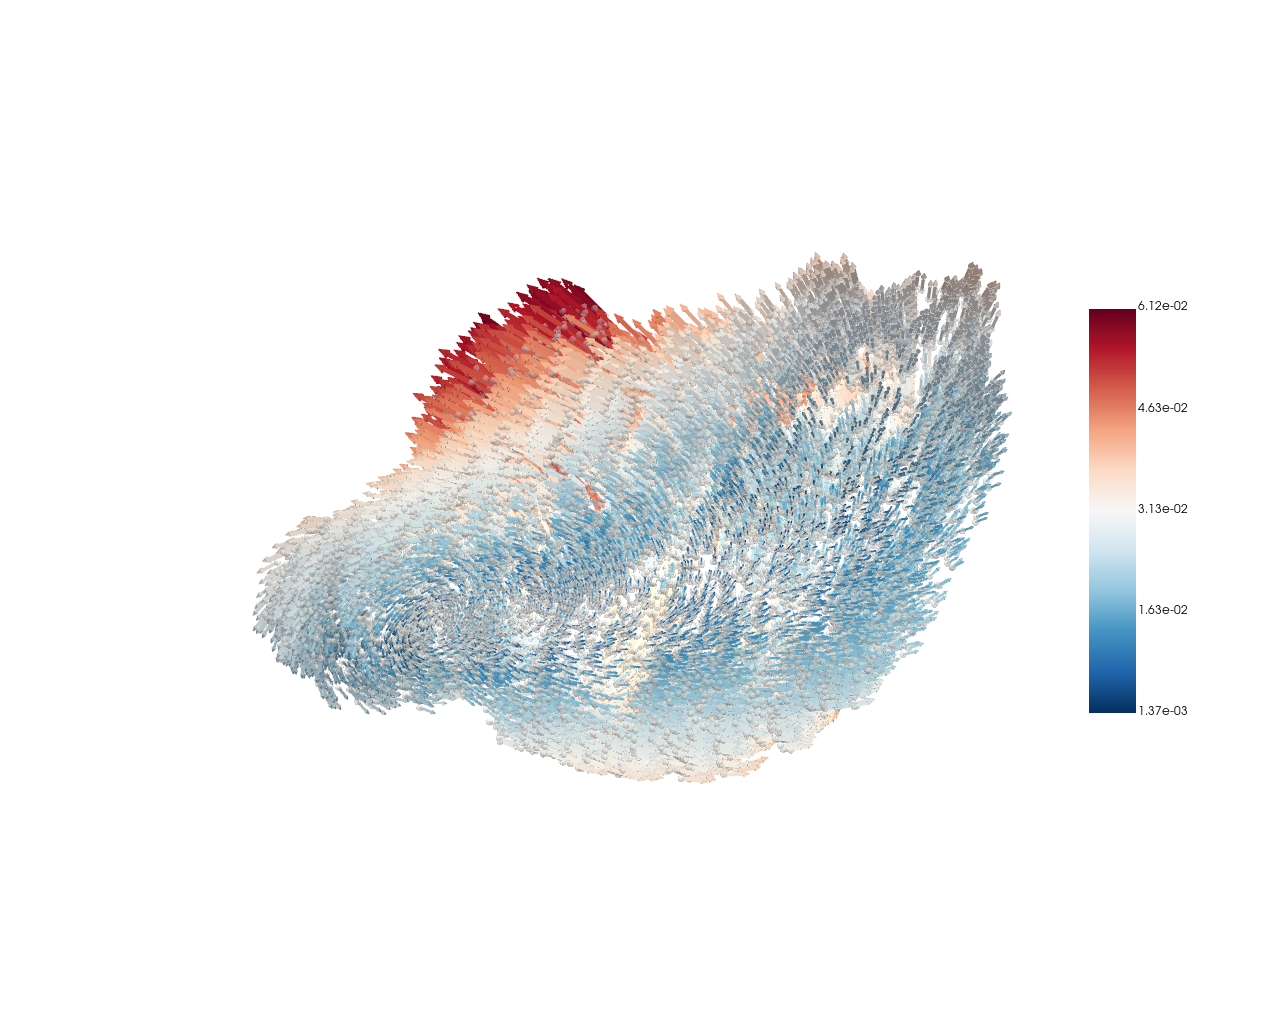

In [16]:
E95_adata.uns['VecFld_morpho'] = E95_mapped_adata.uns['VecFld_morpho']

st.tdr.morphofield_gp(
    adata=E95_adata,
    spatial_key="3d_align_spatial",
    vf_key="VecFld_morpho",
    NX=np.asarray(E95_adata.obsm['3d_align_spatial']),
    inplace=True,
)

E95_heart_pc, _ = st.tdr.construct_pc(adata=E95_adata,spatial_key="3d_align_spatial",groupby="heart_regions",key_added="heart_regions", colormap=regions_colors)
E95_heart_pc.point_data["vectors"] = E95_adata.uns["VecFld_morpho"]["V"]
E95_heart_arrows, _ = st.tdr.construct_field(
    model=E95_heart_pc, vf_key="vectors", arrows_scale_key="vectors", n_sampling=None, factor=1000, key_added="obs_index",
    label=np.asarray(E95_heart_pc.point_data["obs_index"]), 
)
st.pl.three_d_plot(
    model=st.tdr.collect_models([E95_heart_pc, E95_heart_arrows]),
    key=["heart_regions", "v_arrows"],
    colormap=["gainsboro", "RdBu_r"],
    opacity=[0.4, 1],
    model_style=["points", "wireframe"],
    model_size=[7, 1],
    jupyter="static",
    cpo="yz",
    window_size=(1280, 1024),
)

Since the migration field is in an analytical form, we can perform integration to predict short-term cell migration trajectories. ``st.tdr.morphopath`` sloves an ivp problem and the following functions provide visualization.

uniformly sampling points along a trajectory: 100%|████████████████████████████████████████████████████████| 19780/19780 [00:15<00:00, 1286.78it/s]


|-----? The number of start_points is more than 500. You may want to lower the max number of arrows to draw.


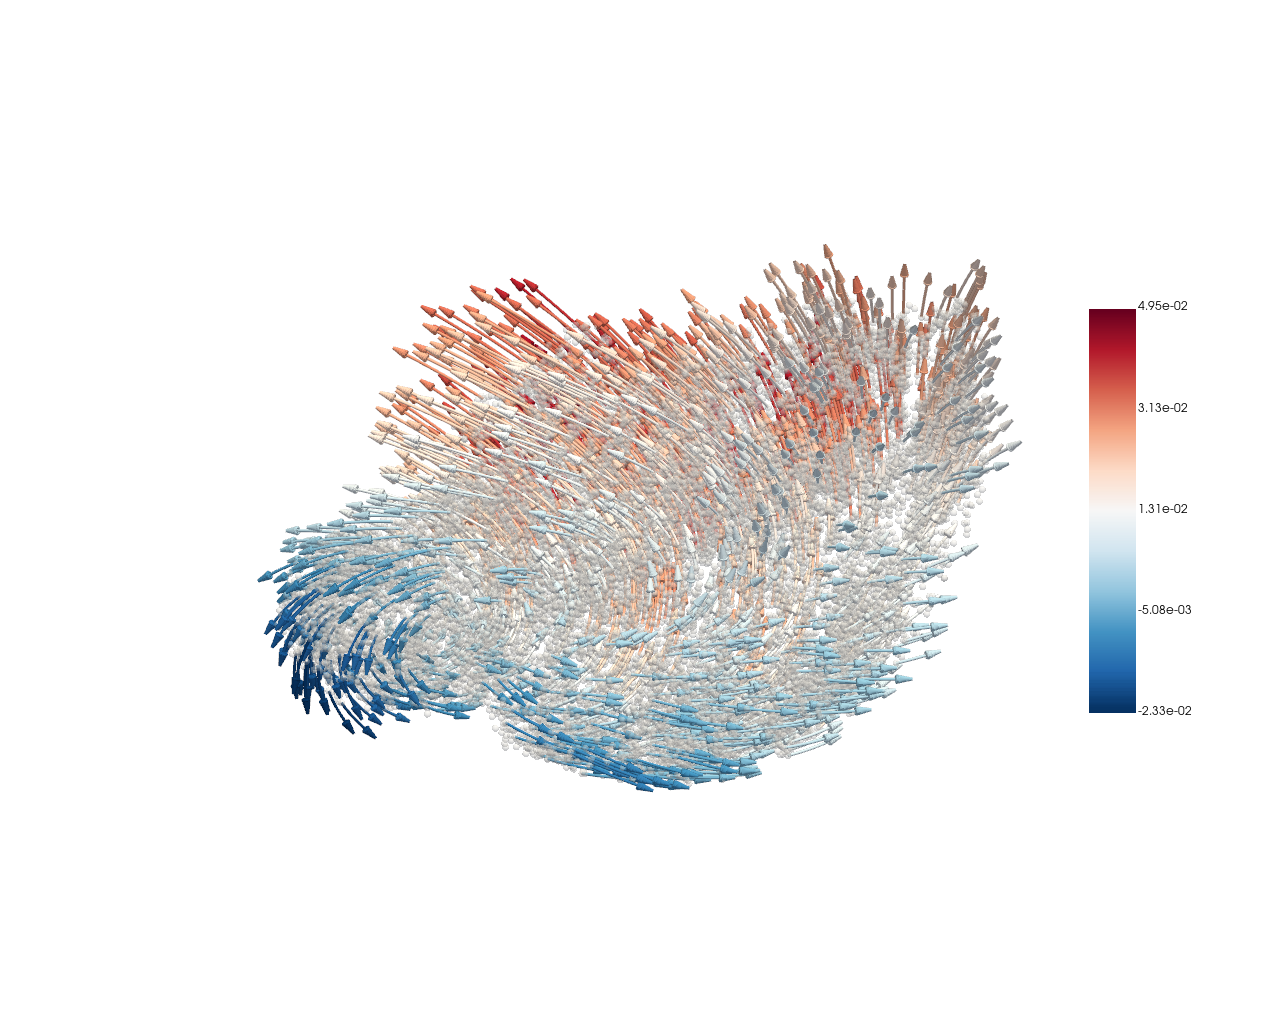

In [18]:
st.tdr.morphopath(
    adata=E95_adata,
    vf_key="VecFld_morpho",
    key_added="fate_morpho",
    t_end=2000,
    interpolation_num=10,
    cores=1,
)
E95_heart_paths, _ = st.tdr.construct_trajectory(
    adata=E95_adata,
    fate_key="fate_morpho",
    n_sampling=2000,
    sampling_method="random",
    key_added="obs_index",
    tip_factor=20,
    label=np.asarray(E95_adata.obs.index),
)

E95_adata.obs["V_z"] = E95_adata.uns["VecFld_morpho"]["V"][:, 2].flatten()
st.tdr.add_model_labels(
    model=E95_heart_paths,
    key_added="trajectory",
    labels=np.asarray(E95_adata[np.asarray(E95_heart_paths.point_data["obs_index"])].obs["V_z"]),
    colormap="RdBu_r",
    where="point_data",
    inplace=True,
)
st.pl.three_d_plot(
    model=st.tdr.collect_models([E95_heart_pc, E95_heart_paths]),
    key=["heart_regions", "trajectory"],
    colormap=["gainsboro", "RdBu_r"],
    opacity=[0.4, 1],
    model_style=["points", "wireframe"],
    model_size=[7, 3],
    jupyter="static",
    cpo="yz",
    window_size=(1280, 1024),
)

We describe the average migration direction for different heart regions

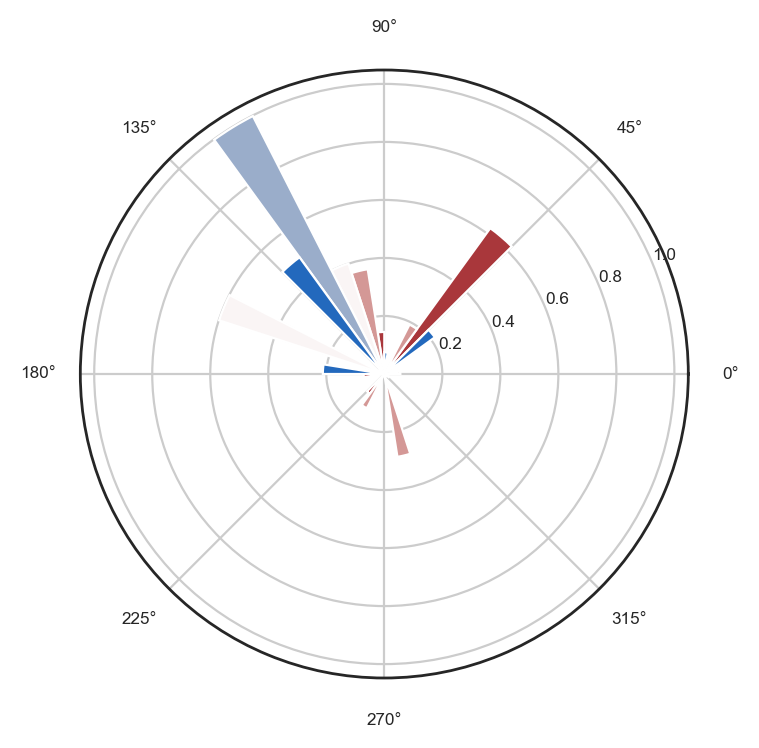

In [19]:
v_data = pd.DataFrame(E95_adata.uns["VecFld_morpho"]["V"], index=E95_adata.obs.index, columns=["X", "Y", "Z"])
v_data["heart_regions"] = E95_adata.obs["heart_regions"]

ax = plt.subplot(projection='polar')
quadrants = ["+_+_+", "-_+_+", "-_-_+", "+_-_+", "+_+_-", "-_+_-", "-_-_-", "+_-_-"]
for i, region in enumerate(regions):
    sub_v_data = v_data.loc[v_data["heart_regions"] == region, :]
    sub_v_data["quadrant_X"] = sub_v_data["X"].map(lambda x: "+_" if x >=0 else "-_")
    sub_v_data["quadrant_Y"] = sub_v_data["Y"].map(lambda x: "+_" if x >=0 else "-_")
    sub_v_data["quadrant_Z"] = sub_v_data["Z"].map(lambda x: "+" if x >=0 else "-")
    sub_v_data["quadrant"] = sub_v_data["quadrant_X"] + sub_v_data["quadrant_Y"] + sub_v_data["quadrant_Z"]
    quadrant_count_data = sub_v_data.groupby(by="quadrant")["quadrant"].count()
    quadrant_count_data = quadrant_count_data / quadrant_count_data.sum()
    for ind in quadrant_count_data.index:
        q = quadrants.index(ind)
        theta = (i * 1/4/5 + 1/4/5/2)*np.pi+q/4*np.pi
        radii = quadrant_count_data.loc[ind]
        width = 1/4/5 * np.pi
        ax = plt.subplot(projection='polar')
        ax.bar(theta, radii, width=width, bottom=0.0, color=regions_colors[region], alpha=1)
plt.show()

## Differential Geometry Quantities

Next, we calculate the differential geometry of the migration field using the ``st.tdr.morphofield_xxx`` function (support acceleration, curvature, torsion, divergence, jacobian, and velocity) and visualize the results. Here, we showcase **acceleration**, **curl**, and **divergence**, which are related to heart twisting and expansion

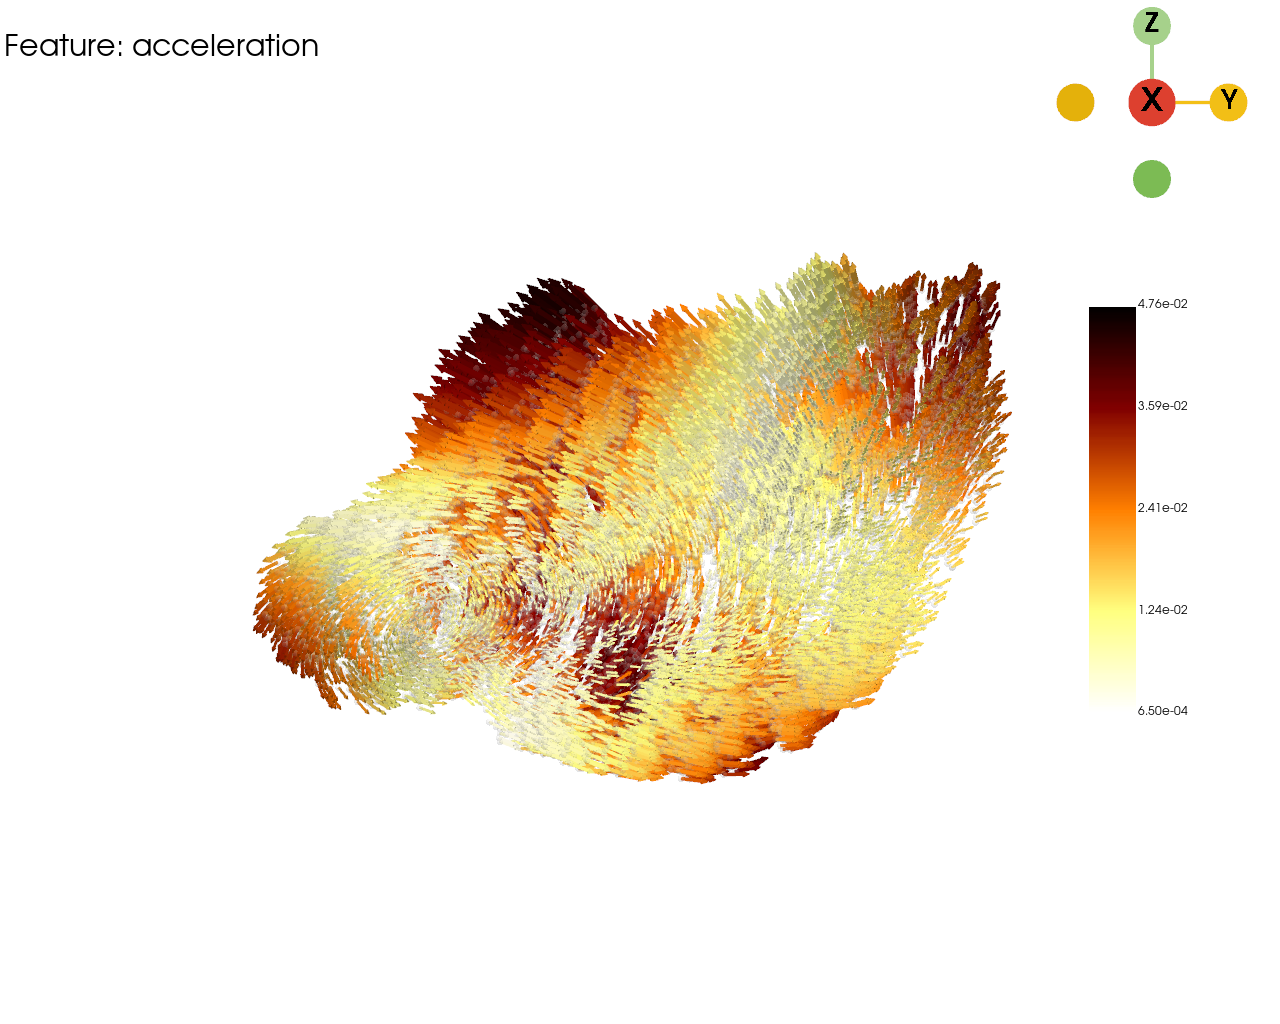

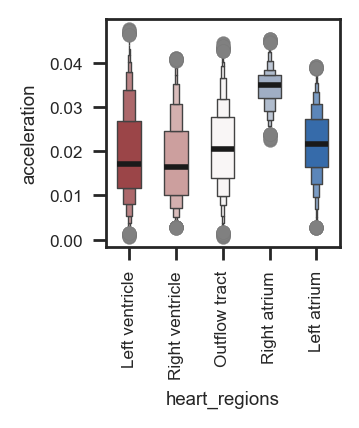

In [20]:
key = "acceleration"
st.tdr.morphofield_acceleration(adata=E95_adata, vf_key="VecFld_morpho",  key_added=key)
st.pl.acceleration(
    adata=E95_adata,
    model=st.tdr.collect_models([E95_heart_pc, E95_heart_arrows]),
    acceleration_key=key,
    colormap=["gainsboro", "afmhot_r"],
    model_style=["points", "wireframe"],
    opacity=[0.2, 1],
    model_size=[7, 1],
    jupyter="static",
    cpo="yz",
    window_size=(1280, 1024),
    background="white",
)

f, ax = plt.subplots(figsize=(1.5, 1.5))
sns.boxenplot(E95_adata.obs[["heart_regions", key]], x="heart_regions", y=key, palette=regions_colors, order=regions, linewidth=.5, line_kws=dict(linewidth=2, color="k"), flier_kws=dict(facecolor=".5", linewidth=.1), width=.5)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

Calculating 3-D curl: 100%|███████████████████████████████████████████████████████████████████████████████| 19780/19780 [00:01<00:00, 15032.36it/s]


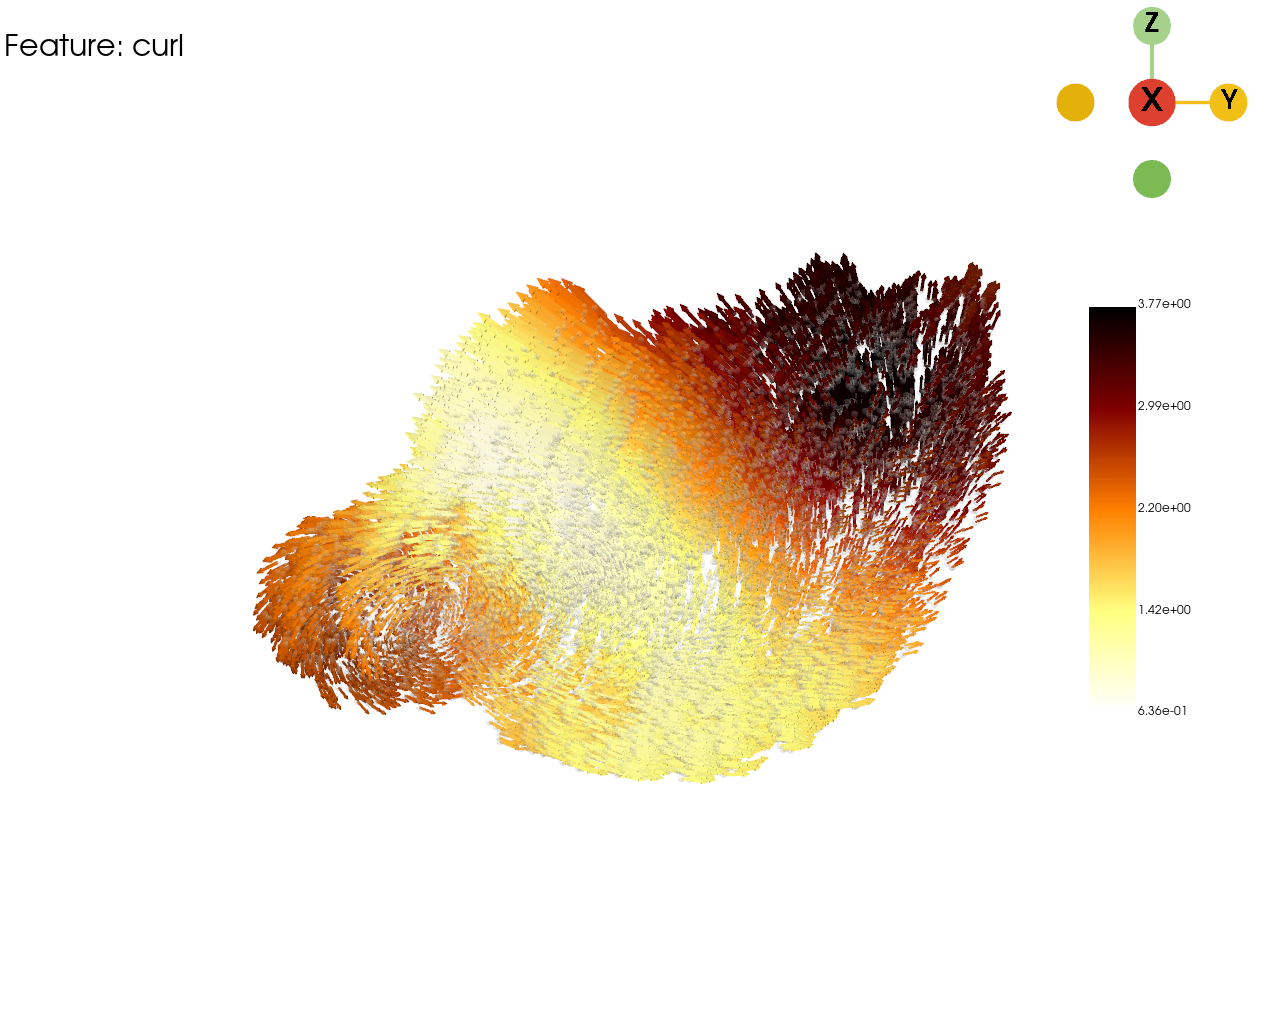

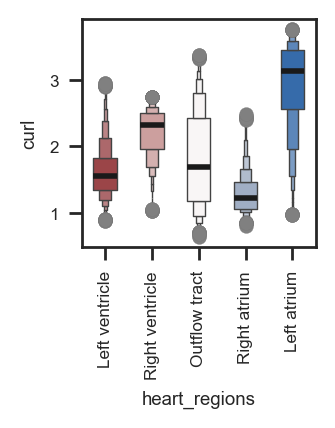

In [21]:
key = "curl"
st.tdr.morphofield_curl(adata=E95_adata, vf_key="VecFld_morpho",  key_added=key)
st.pl.curl(
    adata=E95_adata,
    model=st.tdr.collect_models([E95_heart_pc, E95_heart_arrows]),
    curl_key=key,
    colormap=["gainsboro", "afmhot_r"],
    model_style=["points", "wireframe"],
    opacity=[0.2, 1],
    model_size=[7, 1],
    jupyter="static",
    cpo="yz",
    window_size=(1280, 1024),
    background="white",
)

f, ax = plt.subplots(figsize=(1.5, 1.5))
sns.boxenplot(E95_adata.obs[["heart_regions", key]], x="heart_regions", y=key, palette=regions_colors, order=regions, linewidth=.5, line_kws=dict(linewidth=2, color="k"), flier_kws=dict(facecolor=".5", linewidth=.1), width=.5)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

Calculating divergence: 100%|██████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 22.12it/s]


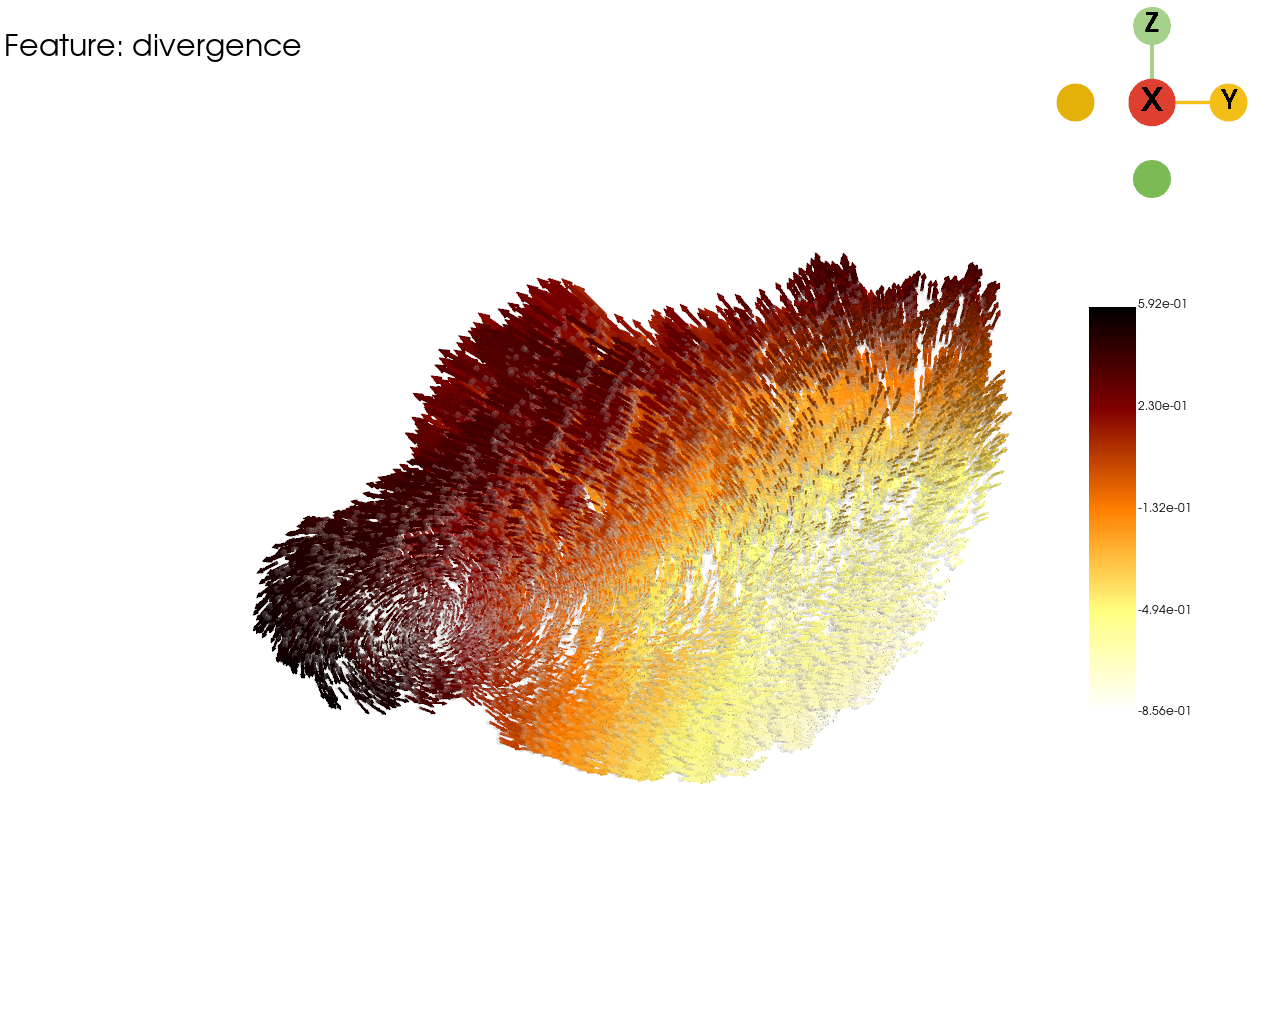

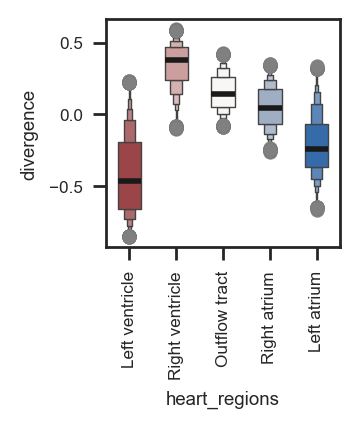

In [22]:
key = "divergence"
st.tdr.morphofield_divergence(adata=E95_adata, vf_key="VecFld_morpho",  key_added=key)
st.pl.divergence(
    adata=E95_adata,
    model=st.tdr.collect_models([E95_heart_pc, E95_heart_arrows]),
    divergence_key=key,
    colormap=["gainsboro", "afmhot_r"],
    model_style=["points", "wireframe"],
    opacity=[0.2, 1],
    model_size=[7, 1],
    jupyter="static",
    cpo="yz",
    window_size=(1280, 1024),
    background="white",
)

f, ax = plt.subplots(figsize=(1.5, 1.5))
sns.boxenplot(E95_adata.obs[["heart_regions", key]], x="heart_regions", y=key, palette=regions_colors, order=regions, linewidth=.5, line_kws=dict(linewidth=2, color="k"), flier_kws=dict(facecolor=".5", linewidth=.1), width=.5)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

## Detect potential ''morphogenic genes''

We next detected a set of ''morphogenic genes'' that are highly correlated with morphometric curl, acceleration, and divergence, using the GLM regression. 

In [ ]:
st.tl.glm_degs(
    adata=E95_adata,
    fullModelFormulaStr=f'~cr(acceleration, df=3)',
    key_added="glm_degs",
    qval_threshold=0.01,
    llf_threshold=-100,
)

glm_data = pd.DataFrame(adata.uns["glm_degs"]["glm_result"])

glm_data.to_csv(os.path.join(img_out_dir, f"mouse_{morpho_id}_morphofield_model_{key}_glm_degs.csv"), sep="\t")

## Show the spatial patterns of the morphogenic genes

After identifying the morphogenic genes, we select three genes—Angpt1, Pitx2, and Hey2—which are associated with the morphogenesis of the right atrial chambers, left/right asymmetric formation, and ventricular formation, respectively, to visualize their 3D spatial patterns.

{'obs_keys': [], 'var_keys': ['Angpt1']}
|-----> [Interpolation based on Gaussian Process Regression for Angpt1] in progress: 100.0000%
|-----> [Interpolation based on Gaussian Process Regression for Angpt1] finished [35.4168s]
|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [1791.9028s]


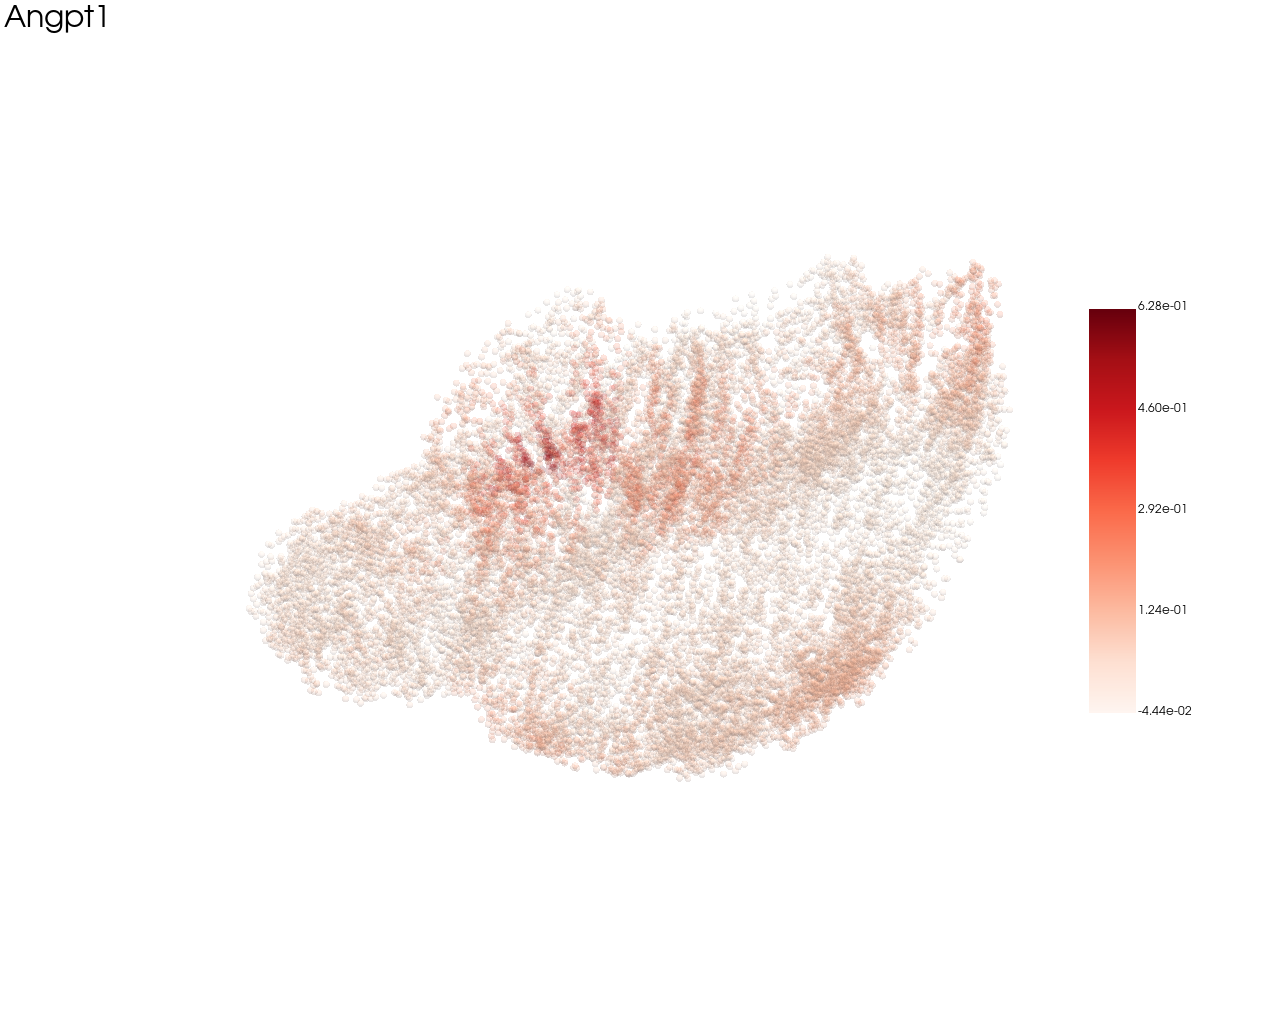

{'obs_keys': [], 'var_keys': ['Pitx2']}
|-----> [Interpolation based on Gaussian Process Regression for Pitx2] in progress: 100.0000%
|-----> [Interpolation based on Gaussian Process Regression for Pitx2] finished [36.0501s]
|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [37.1533s]


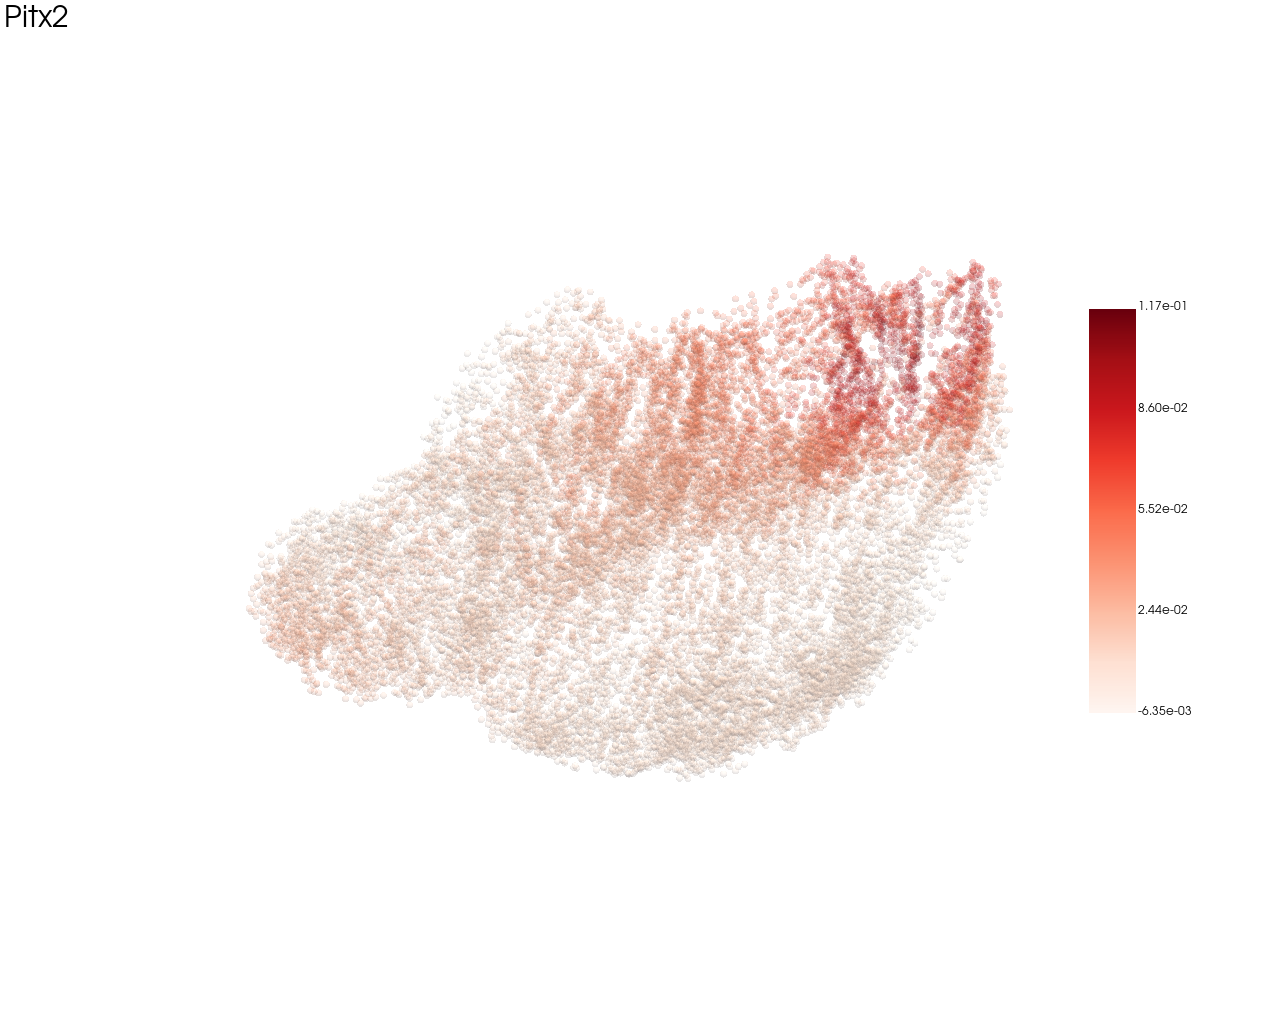

{'obs_keys': [], 'var_keys': ['Hey2']}
|-----> [Interpolation based on Gaussian Process Regression for Hey2] in progress: 100.0000%
|-----> [Interpolation based on Gaussian Process Regression for Hey2] finished [35.5600s]
|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [36.6090s]


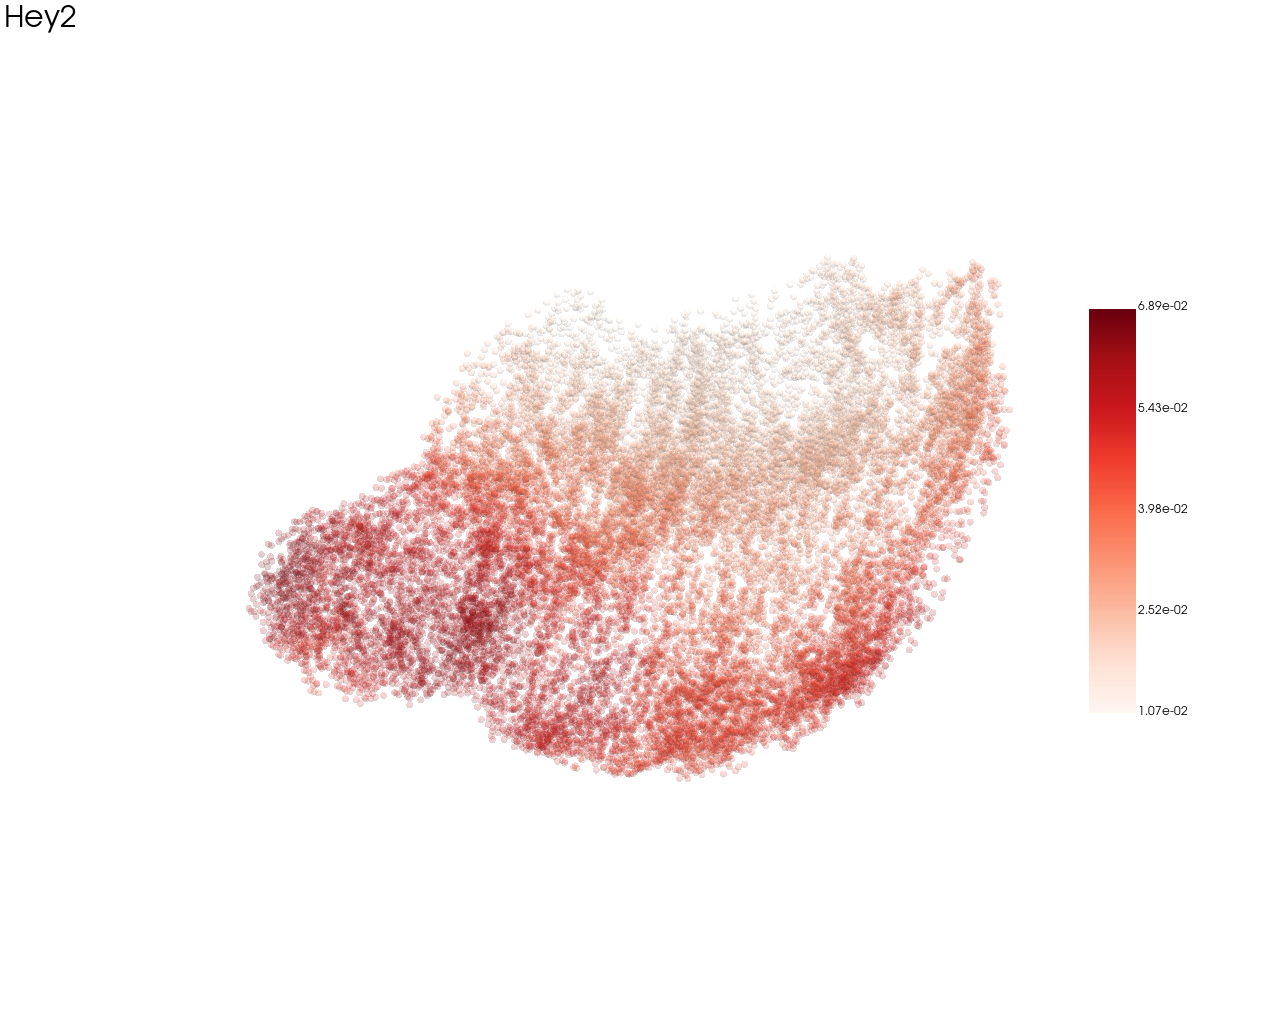

In [23]:
for gn in ['Angpt1', 'Pitx2', 'Hey2']:
    interpolated_gp_adata = st.tdr.gp_interpolation(source_adata=E95_adata.copy(), spatial_key="3d_align_spatial", keys=gn,
                                                    target_points=np.asarray(E95_pc.points), device="0",training_iter=100)
    interpolated_gp_pc, _ = st.tdr.construct_pc(adata=interpolated_gp_adata.copy(), spatial_key="3d_align_spatial", groupby=gn,
                                                key_added=gn)
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    st.pl.three_d_plot(
        model = interpolated_gp_pc,
        key = gn,
        model_style = "points",
        model_size = 7,
        opacity = 0.2,
        colormap = "Reds",
        show_legend = True,
        jupyter = "static",
        off_screen = False,
        cpo = "yz",
        window_size = (1280, 1024),
        text = gn,
    )